<a href="https://colab.research.google.com/github/mvfolino68/google_vision/blob/master/GoogleVisionAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install google.cloud.vision
import os
import io
import requests
import argparse
from enum import Enum

from google.cloud import vision
from google.cloud.vision import types
from PIL import Image, ImageDraw
from IPython.display import display # to display images

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/sturdy-spanner-221114-891167b05110.json"
!echo $GOOGLE_APPLICATION_CREDENTIALS

  Using cached https://files.pythonhosted.org/packages/ec/e3/77b17733592fde11b7250444ddedd8d04ae1be6f0f4c0d9f47ed154a686e/google_cloud_vision-0.39.0-py2.py3-none-any.whl
/content/sturdy-spanner-221114-891167b05110.json


In [0]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5


def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image


def get_document_bounds(image_file, feature):
    # [START vision_document_text_tutorial_detect_bounds]
    """Returns document bounds given an image."""
    client = vision.ImageAnnotatorClient()

    bounds = []
    urlimg = requests.get(image_file, stream=True)
    content = urlimg.content
    # with io.open(image_file, 'rb') as image_file:
    #     content = image_file.read()

    image = types.Image(content=content)

    response = client.document_text_detection(image=image)
    document = response.full_text_annotation

    # Collect specified feature bounds by enumerating all document features
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)

                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)

                if (feature == FeatureType.PARA):
                    bounds.append(paragraph.bounding_box)

            if (feature == FeatureType.BLOCK):
                bounds.append(block.bounding_box)

        if (feature == FeatureType.PAGE):
            bounds.append(block.bounding_box)

    # The list `bounds` contains the coordinates of the bounding boxes.
    # [END vision_document_text_tutorial_detect_bounds]
    return bounds


def render_doc_text(filein, fileout):
    image = Image.open(requests.get(filein, stream=True).raw)
    bounds = get_document_bounds(filein, FeatureType.PAGE)
    draw_boxes(image, bounds, 'blue')
    bounds = get_document_bounds(filein, FeatureType.PARA)
    draw_boxes(image, bounds, 'red')
    bounds = get_document_bounds(filein, FeatureType.WORD)
    draw_boxes(image, bounds, 'yellow')

    if fileout != 0:
        image.save(fileout)
    else:
        display(image)

In [0]:
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    # with io.open(path, 'rb') as image_file:
    #     content = image_file.read()
    urlimg = requests.get(path, stream=True)
    content = urlimg.content
    image = vision.types.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

        # vertices = (['({},{})'.format(vertex.x, vertex.y)
        #             for vertex in text.bounding_poly.vertices])

        # print('bounds: {}'.format(','.join(vertices)))

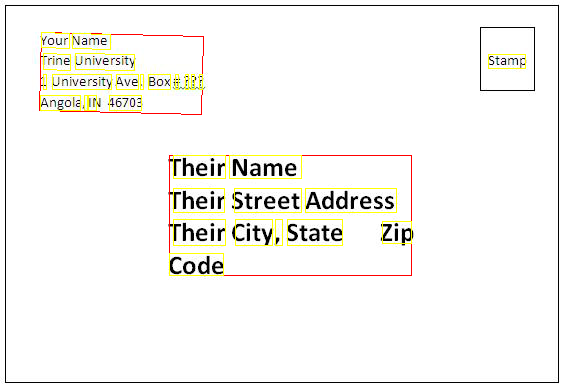

Texts:

"Your Name
Trine University
Stamp
1 University Ave. Box #???
Angola, IN 46703
Their Name
Their Street Address
Their City, State
Zip
Code
"

"Your"

"Name"

"Trine"

"University"

"Stamp"

"1"

"University"

"Ave."

"Box"

"#???"

"Angola,"

"IN"

"46703"

"Their"

"Name"

"Their"

"Street"

"Address"

"Their"

"City,"

"State"

"Zip"

"Code"


In [0]:
image = 'http://laimages.s3.amazonaws.com/data/imagemanager/4337/address.jpg'
render_doc_text(image, 0)
detect_text(image)